In [1]:
from src.data_structures.instance import Instance
from src.solvers.ZeroReductor.DLHEU2 import DHEU
from src.data_structures.features import *
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /build/python-pytorch/src/pytorch-opt/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2

validation_data_folder = Path("validation_data")
training_data_folder = Path("training_data")

In [3]:
key= lambda x: x.n_items
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=key)

evaluation_instances = list(iter(map(Instance.from_file,validation_data_folder.iterdir())))
evaluation_instances.sort(key=key)




In [4]:
features: list[ItemBatchFeature] = [
            ProfitOverBudget(),
            LowerCostOverBudget(),
            UpperCostOverBudget(),
            IsInContSol(),
            #CountPSynergiesOverNItems(),
            #CountPSynergiesOverBudget(),
            GammaOverNItems(),
            #SumOfSynergiesByItemOverMaxSinergyProfit(),
            Noise()
            ]



In [5]:
heu = DHEU(features)

In [11]:
#heu.train(training_data_folder)
loss = []
for epoch, instance in enumerate(instances):
    x = heu.gen_x(instance).T
    y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
    if len(y) == 0: #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
        continue
    heu.optimizer.zero_grad()
    total_loss = 0
    y_pred = heu.net(x)
    batch_loss = heu.criterion(y_pred,y)
    batch_loss.backward()
    heu.optimizer.step()
    total_loss += batch_loss.item()
    loss.append((total_loss/2,instance))
    sys.stdout.write(f'\rEpoch {epoch},Presicion {1-(total_loss/2)} {str(instance)}')
    sys.stdout.flush()

Epoch 2183,Presicion 0.9501495603883492 Instance(2500,50,#8764986898425)

In [12]:
heu.save(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2.model"))

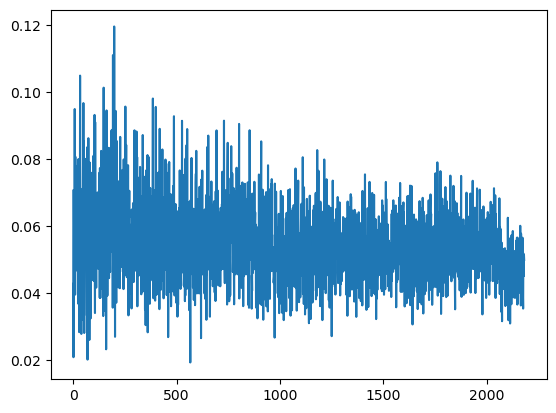

In [13]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(loss))],[i[0] for i in loss])

In [14]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.07051557556934758 Instance(100,23,#8765077243305)
0.02081980918218245 Instance(100,40,#8765075816497)
0.042908530367960884 Instance(100,62,#8765075590181)
0.03852204618525451 Instance(100,88,#8765073985965)
0.06757921387107892 Instance(100,26,#8765073397749)
0.061861079967717954 Instance(100,97,#8765074006573)
0.06626161279111263 Instance(100,92,#8764987054385)
0.09485273999422669 Instance(101,50,#8765081361793)
0.059228858723261314 Instance(101,18,#8765074592157)
0.039486399864950894 Instance(101,93,#8765074195833)
0.08062320896328709 Instance(101,81,#8765073800149)
0.07053732923803095 Instance(101,47,#8764987503417)
0.046602578959907694 Instance(102,17,#8765075631189)
0.07767446680512773 Instance(102,77,#8765072815101)
0.06536944664358445 Instance(102,80,#8765072339237)
0.07019155631108066 Instance(102,12,#8765072153597)
0.0504707541590523 Instance(103,78,#8765073284093)
0.051636438354112406 Instance(103,83,#8764986860009)
0.06179913983638411 Instance(104,97,#8765081361945)
0.04984

Presicion 90.082%
STD 1.849%


(array([ 1.,  7., 18., 22., 20., 13., 11.,  3.,  3.,  2.]),
 array([0.05769345, 0.06725695, 0.07682045, 0.08638395, 0.09594745,
        0.10551095, 0.11507445, 0.12463795, 0.13420145, 0.14376495,
        0.15332845]),
 <BarContainer object of 10 artists>)

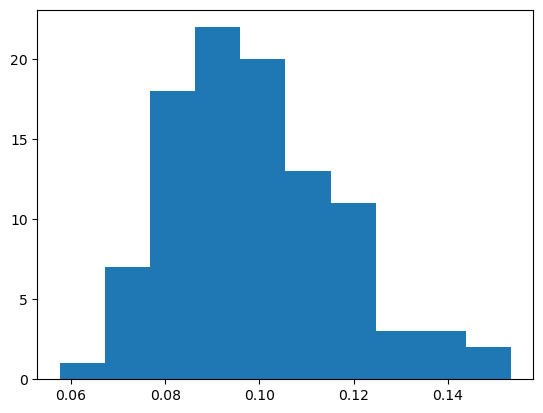

In [15]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")

plt.hist(losses)